# Data generation and analysis for effect of isotropic error on Grover's Algorithm

## Data generation

In [1]:
from isotropic.utils.data_generation import generate_data

num_qubits = 5
min_iterations = 1
max_iterations = 5
min_sigma = 0.9
max_sigma = 0.99
num_sigma_points = 4
num_jobs = 4
data_dir = "data"

generate_data(
    num_qubits=num_qubits,
    min_iterations=min_iterations,
    max_iterations=max_iterations,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma_points=num_sigma_points,
    num_jobs=num_jobs,
    data_dir=data_dir,
)

## Data analysis

We are interested in the following trends:

* success probability vs iterations for different values of sigma
* minimum iterations vs success probability for different sigma values
* success probability vs sigma for a specific number of iterations 

In [2]:
import xarray as xr
from pathlib import Path

# glob through all files for a specific number of qubits in the data directory
path = Path("data")
files = sorted(path.glob("grover_5_qubits_*.nc"))

datasets = [xr.open_dataset(file) for file in files]

### Success probability vs number of iterations for different sigma values

/Users/anurag/dev/isotropic-error-analysis/.venv/lib/python3.11/site-packages/xarray/structure/concat.py:674: UserWarning: No index created for dimension iterations because variable iterations is not a coordinate. To create an index for iterations, please first call `.set_coords('iterations')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


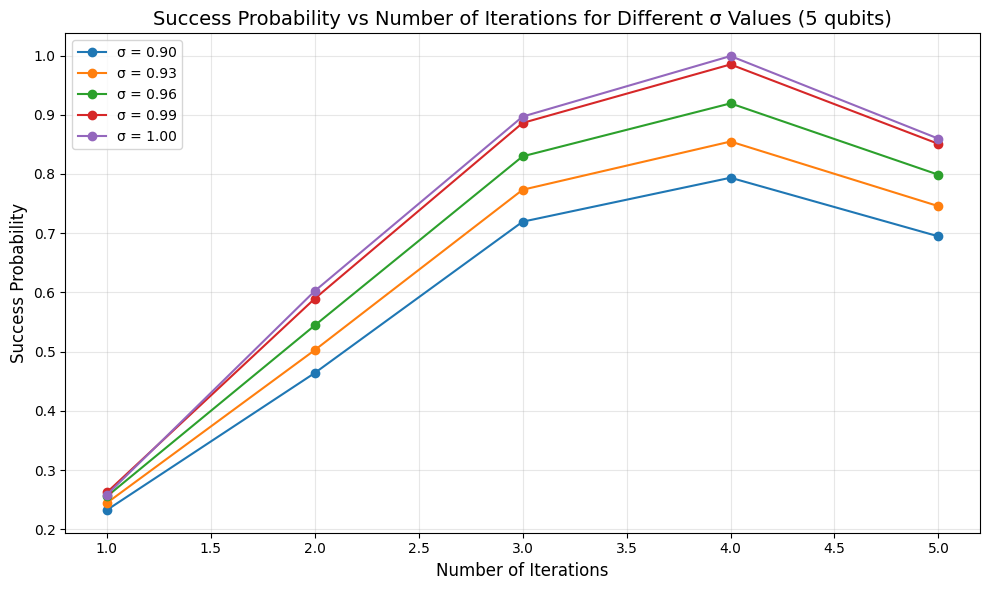

In [3]:
import matplotlib.pyplot as plt

# Combine all datasets into a single dataset with iterations as a dimension
combined_data = xr.concat(datasets, dim="iterations")

sigma_values = datasets[0]["sigma"]

# Create the plot
plt.figure(figsize=(10, 6))

for sigma_val in sigma_values:
    # Select data for this sigma value (using nearest neighbor selection)
    data_for_sigma = combined_data.sel(sigma=sigma_val, method="nearest")
    iterations = data_for_sigma["iterations"].values
    success_prob = data_for_sigma["success_probability"].values

    plt.plot(iterations, success_prob, marker="o", label=f"σ = {sigma_val:.2f}")

plt.xlabel("Number of Iterations", fontsize=12)
plt.ylabel("Success Probability", fontsize=12)
plt.title(
    f"Success Probability vs Number of Iterations for Different σ Values ({datasets[0].num_qubits} qubits)",
    fontsize=14,
)
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    f"grover_success_probability_vs_iterations_{datasets[0].num_qubits}q.svg", dpi=800
)
plt.show()

### Minimum iterations required vs success probability threshold for different sigma values

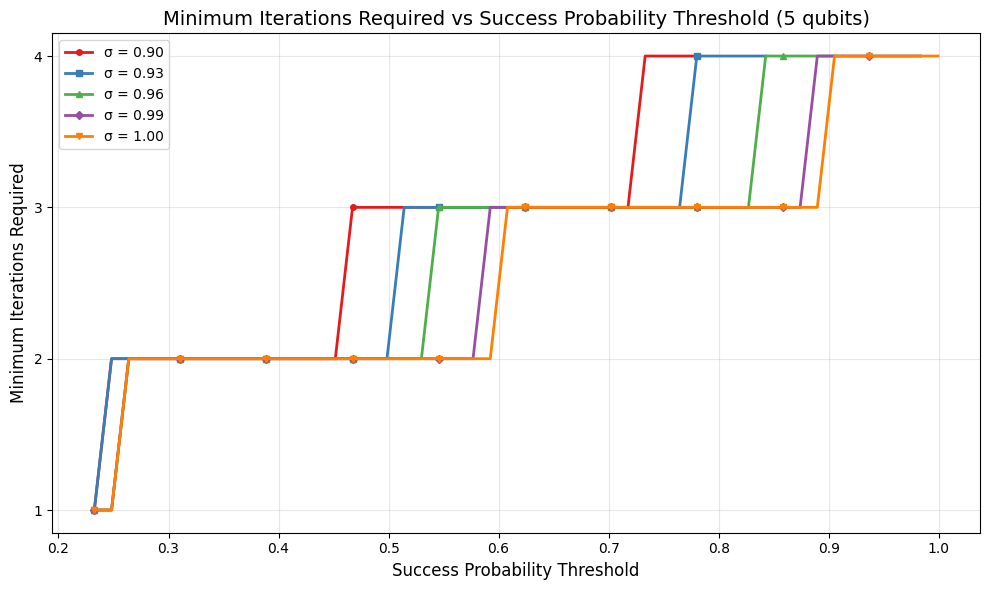

In [4]:
import numpy as np

# Define the sigma values to plot
target_sigmas = [0.90, 0.93, 0.96, 0.99, 1.0]

# Get all available iterations from the combined data
all_iterations = sorted(combined_data["iterations"].values)

# Get the range of success probabilities from the data to define thresholds
all_success_probs = combined_data["success_probability"].values.flatten()
min_prob = np.nanmin(all_success_probs)
max_prob = np.nanmax(all_success_probs)
success_thresholds = np.linspace(min_prob, max_prob, 50)


# Function to find minimum iterations required for a given sigma and threshold
def find_min_iterations(combined_data, sigma_val, threshold):
    """Find the minimum number of iterations to achieve the success threshold."""
    for iters in all_iterations:
        data_point = combined_data.sel(
            iterations=iters, sigma=sigma_val, method="nearest"
        )
        if data_point["success_probability"].values >= threshold:
            return iters
    return np.nan  # Return NaN if threshold is never reached


# Compute minimum iterations for each (sigma, threshold) pair
min_iterations_data = {sigma: [] for sigma in target_sigmas}

for sigma_val in target_sigmas:
    for threshold in success_thresholds:
        min_iters = find_min_iterations(combined_data, sigma_val, threshold)
        min_iterations_data[sigma_val].append(min_iters)

# Create the plot
plt.figure(figsize=(10, 6))

markers = ["o", "s", "^", "D", "v"]
# High contrast color palette
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

for i, sigma_val in enumerate(target_sigmas):
    plt.plot(
        success_thresholds,
        min_iterations_data[sigma_val],
        marker=markers[i],
        color=colors[i],
        linewidth=2,
        markersize=4,
        markevery=5,
        label=f"σ = {sigma_val:.2f}",
    )

plt.xlabel("Success Probability Threshold", fontsize=12)
plt.ylabel("Minimum Iterations Required", fontsize=12)
plt.title(
    f"Minimum Iterations Required vs Success Probability Threshold ({datasets[0].num_qubits} qubits)",
    fontsize=14,
)
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig(
    f"grover_min_iterations_vs_success_prob_{datasets[0].num_qubits}q.svg", dpi=800
)
plt.show()

### Success Probability vs Sigma

In [5]:
qubits_and_iterations = [(4, 3), (5, 4)]
min_sigma = 0.7
max_sigma = 0.99
num_sigma_points = 5
num_jobs = 4
data_dir = "data_success_sigma"

for num_qubits, iterations in qubits_and_iterations:
    generate_data(
        num_qubits=num_qubits,
        min_iterations=iterations,
        max_iterations=iterations,
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        num_sigma_points=num_sigma_points,
        num_jobs=num_jobs,
        data_dir=data_dir,
    )

/Users/anurag/dev/isotropic-error-analysis/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [6]:
path = Path(data_dir)
files = sorted(path.glob("grover_*.nc"))
datasets = [xr.open_dataset(file) for file in files]

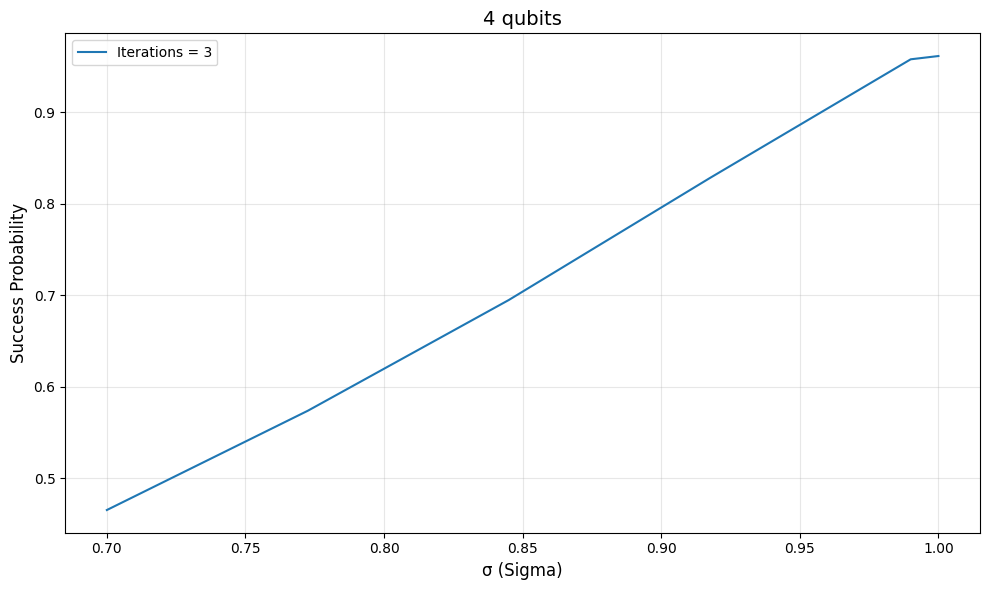

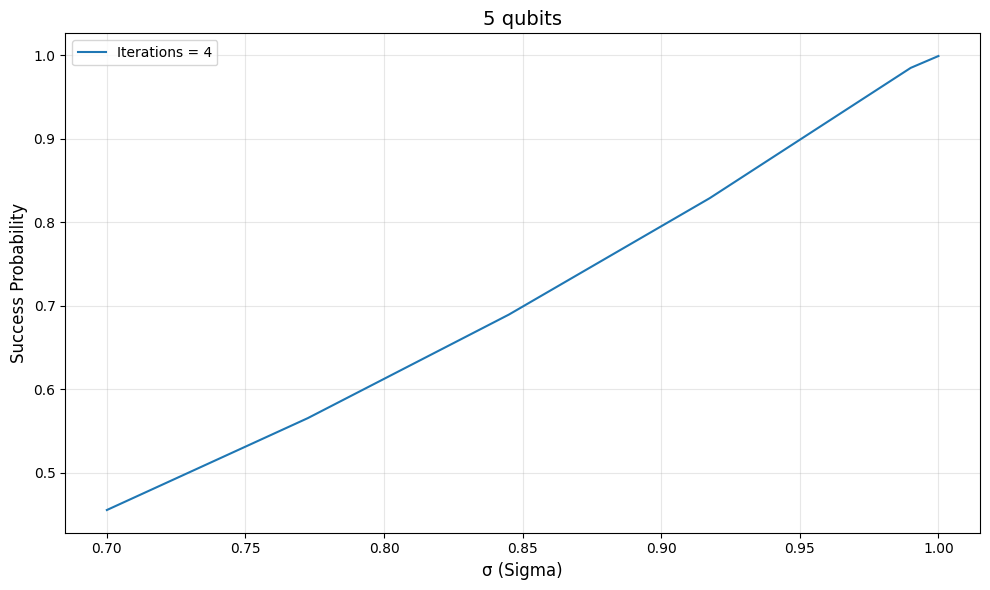

In [7]:
# Create separate plots for each number of qubits. In each plot, plot success probability vs sigma
num_qubits_list = sorted(set(ds.num_qubits.item() for ds in datasets))
for num_qubits in num_qubits_list:
    plt.figure(figsize=(10, 6))
    for ds in datasets:
        if ds.num_qubits.item() == num_qubits:
            sigma_values = ds["sigma"].values
            success_probs = ds["success_probability"].values
            plt.plot(
                sigma_values,
                success_probs,
                label=f"Iterations = {ds.iterations.item()}",
            )

    plt.xlabel("σ (Sigma)", fontsize=12)
    plt.ylabel("Success Probability", fontsize=12)
    plt.title(
        f"{num_qubits} qubits",
        fontsize=14,
    )
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"grover_success_probability_vs_sigma_{num_qubits}q.svg", dpi=800)
    plt.show()